This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [**Embedding Projector**](http://projector.tensorflow.org/) (shown in the image below).

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).
   
There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).
   
* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [1]:
import tensorflow as tf
print('tensorflow: ' + tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

tensorflow: 2.3.0


### Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [**Embedding**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [2]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [3]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.03454282, -0.01835843, -0.02310777,  0.02902203, -0.00759619],
       [-0.01479404, -0.02791754,  0.04462622,  0.02927934, -0.00836229],
       [ 0.02443666, -0.01821113,  0.00185964,  0.03000339, -0.04230387]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (**samples**, **sequence_length**), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a (2, 3) input batch and the output is (2, 3, N)

In [4]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (**samples**, **sequence_length**, **embedding_dimensionality**). To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [**Text Classification with an RNN**](https://www.tensorflow.org/tutorials/text/text_classification_rnn) tutorial is a good next step.

### Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the [**Loading text tutorial**](https://www.tensorflow.org/tutorials/load_data/text).

In [5]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to C:\Users\zy-user\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteILKQFJ\imdb_reviews-train.tfrecord
Shuffling and writing examples to C:\Users\zy-user\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteILKQFJ\imdb_reviews-test.tfrecord
Shuffling and writing examples to C:\Users\zy-user\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteILKQFJ\imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to C:\Users\zy-user\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


Get the encoder ([**tfds.features.text.SubwordTextEncoder**](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder)), and have a quick look at the vocabulary.

The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [6]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the [**padded_batch**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch) method to standardize the lengths of the reviews.

In [15]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

[**tf.random.shuffle**](https://www.tensorflow.org/api_docs/python/tf/random/shuffle): Randomly shuffles a tensor along its first dimension.

[**padded_batch**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch): Combines consecutive elements of this dataset into padded batches.

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [16]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 398,    4,  435, ...,    0,    0,    0],
       [ 133, 5041, 7961, ...,    0,    0,    0],
       [  12, 1974, 3429, ...,    0,    0,    0],
       ...,
       [  19, 2497,   49, ...,    0,    0,    0],
       [ 249,   41, 3454, ...,    0,    0,    0],
       [  62,  907,  101, ...,    2,  794, 7984]], dtype=int64)

### Create a simple mode

We will use the [**Keras Sequential API**](https://www.tensorflow.org/guide/keras/sequential_model) to define our model. In this case it is a "Continuous bag of words" style model.

Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (**batch**, **sequence**, **embedding**).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [9]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.5269 - accuracy: 0.6826 - val_loss: 0.3746 - val_accuracy: 0.8500
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2918 - accuracy: 0.8779 - val_loss: 0.3218 - val_accuracy: 0.8700
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2380 - accuracy: 0.9060 - val_loss: 0.3617 - val_accuracy: 0.8500
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2031 - accuracy: 0.9234 - val_loss: 0.4963 - val_accuracy: 0.8250
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1792 - accuracy: 0.9328 - val_loss: 0.3470 - val_accuracy: 0.8850
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1596 - accuracy: 0.9432 - val_loss: 0.4383 - val_accuracy: 0.8250
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1457 - accuracy: 0.9473 - val_loss: 0.4511 - val_accuracy:

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

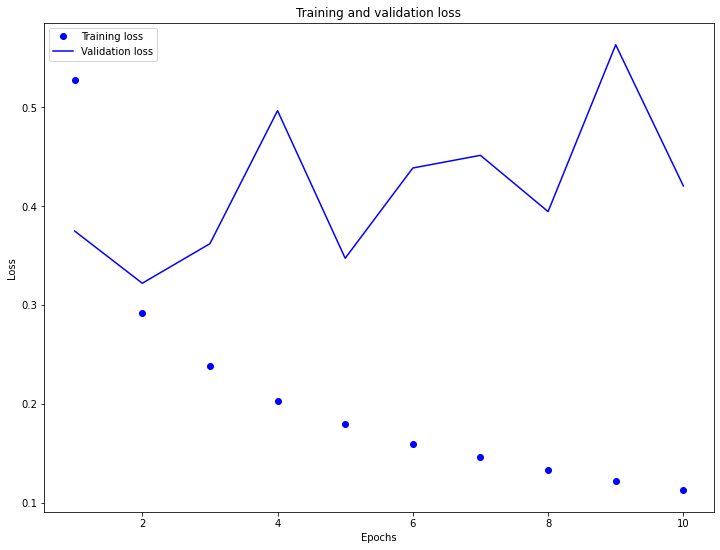

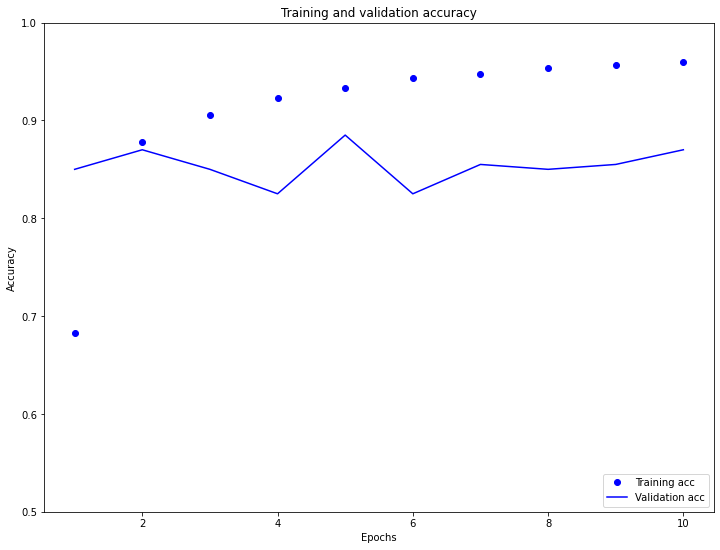

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (**vocab_size**, **embedding-dimension**).

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [**Embedding Projector**](http://projector.tensorflow.org/), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [14]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [**Colaboratory**](https://colab.research.google.com/), you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the **Embedding Projector** (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files we created above: **vecs.tsv** and **meta.tsv**.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".